# Model Optimization Test - 훈련 후 양자화

훈련 후 양자화 적용

ResNet / CIFAR-10 데이터셋으로 실험

TFLite에서는 4가지의 양자화 유형을 지원함

1. 훈련 후 float16 양자화
2. 훈련 후 동적 범위 양자화
3. 훈련 후 정수 양자화
4. 양자화 인식 훈련

이번 노트북에서는 양자화 인식 훈련을 진행하지 않은 모델에 1, 2, 3을 적용하여 모델을 최적화 함.

float16, 동적 범위의 경우 추가적인 데이터가 필요하지 않지만, 정수 양자화의 경우 대표 샘플이 필요함.

Colab GPU에서 모델 훈련 후 Colab의 CPU에서 실험

# Setting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

import keras
import tensorflow as tf

from sklearn.metrics import accuracy_score

In [ ]:
# CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
batch_size = 64

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

preprocess = keras.Sequential([
    keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input)
])

train_set = train_set.map(lambda X, y: (preprocess(X), y)).batch(batch_size).prefetch(1)
test_set = test_set.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

# Base Model

## Train

In [ ]:
# Transfer Learning
# ResNet50
resnet = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

n_classes = 10

avg = keras.layers.GlobalAveragePooling2D()(resnet.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

model = keras.Model(inputs=resnet.input, outputs=output)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, validation_data=test_set, epochs=1)

782/782 [==============================] - 193s 238ms/step - loss: 0.2727 - accuracy: 0.9049 - val_loss: 0.3007 - val_accuracy: 0.8983


In [ ]:
# model save
model_name = 'Base_Model'
model_path = '/content/drive/MyDrive' / Path(model_name)
model.save(model_path, save_format="tf")

## Test

In [ ]:
model_name = 'Base_Model'
model_path = '/content/drive/MyDrive' / Path(model_name)

model = keras.models.load_model(model_path)

In [ ]:
# Add preprocess
base_model = keras.Sequential([preprocess, model])

In [ ]:
Acc_results = {'base_model': [],
               'tflite': [],
               'dynamic_quant': [],
               'float16_quant': [],
               'int_quant': []}

Time_results = {'base_model': [],
               'tflite': [],
               'dynamic_quant': [],
               'float16_quant': [],
               'int_quant': []}

In [ ]:
n_iter = 5

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in X_test[:500]:
        pred = np.argmax(base_model(np.expand_dims(x, axis=0)))
        y_pred.append(pred)

    Acc_results['base_model'].append(accuracy_score(y_test[:500], y_pred))
    end_time = time.time()

    Time_results['base_model'].append(end_time - start_time)

print('Base Model Accuracy (CPU): %f' %(np.mean(Acc_results['base_model'])))
print('Base Model Inference Time (CPU): %f' %(np.mean(Time_results['base_model'])))

Base Model Accuracy (CPU): 0.898000
Base Model Inference Time (CPU): 184.836990


# TFLite

TFLite를 사용한 base_model 경량화

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
tflite_model = converter.convert()

tflite_models_dir = Path("tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"base_model.tflite"
tflite_model_file.write_bytes(tflite_model)

94049004

In [ ]:
# one sample test
interpreter_tflite = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter_tflite.allocate_tensors()

test_image = np.expand_dims(X_test[0], axis=0)

input_index = interpreter_tflite.get_input_details()[0]["index"]
output_index = interpreter_tflite.get_output_details()[0]["index"]

interpreter_tflite.set_tensor(input_index, test_image)
interpreter_tflite.invoke()
predictions = interpreter_tflite.get_tensor(output_index)

predictions

array([[2.6069383e-06, 6.6211354e-04, 1.3438077e-04, 9.9387336e-01,
        3.2347896e-07, 5.2271276e-03, 3.4800763e-05, 2.9433845e-06,
        8.4103085e-06, 5.3893800e-05]], dtype=float32)

In [ ]:
n_iter = 5

input_index = interpreter_tflite.get_input_details()[0]["index"]
output_index = interpreter_tflite.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in X_test[:500]:
        x = np.expand_dims(x, axis=0)
        interpreter_tflite.set_tensor(input_index, x)

        interpreter_tflite.invoke()

        output = interpreter_tflite.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Acc_results['tflite'].append(accuracy_score(y_test[:500], y_pred))
    end_time = time.time()

    Time_results['tflite'].append(end_time - start_time)

print('TFLite Accuracy (CPU): %f' %(np.mean(Acc_results['tflite'])))
print('TFLite Inference Time (CPU): %f' %(np.mean(Time_results['tflite'])))

TFLite Accuracy (CPU): 0.898000
TFLite Inference Time (CPU): 86.163692


# 훈련 후 동적 범위 양자화

동적 범위 양자화는 모델 크기를 4배 줄입니다.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant_model = converter.convert()

tflite_model_dynamic_quant_file = tflite_models_dir/"dynamic_quant_model.tflite"
tflite_model_dynamic_quant_file.write_bytes(tflite_dynamic_quant_model)

23942680

In [ ]:
# one sample test
interpreter_dynamic = tf.lite.Interpreter(model_path=str(tflite_model_dynamic_quant_file))
interpreter_dynamic.allocate_tensors()

test_image = np.expand_dims(X_test[0], axis=0)

input_index = interpreter_dynamic.get_input_details()[0]["index"]
output_index = interpreter_dynamic.get_output_details()[0]["index"]

interpreter_dynamic.set_tensor(input_index, test_image)
interpreter_dynamic.invoke()
predictions = interpreter_dynamic.get_tensor(output_index)

predictions

array([[3.81137806e-06, 1.00892270e-03, 1.36831179e-04, 9.93450999e-01,
        4.02635237e-07, 5.23553835e-03, 7.06569408e-05, 3.57472641e-06,
        1.51993345e-05, 7.40356918e-05]], dtype=float32)

In [ ]:
n_iter = 5

input_index = interpreter_dynamic.get_input_details()[0]["index"]
output_index = interpreter_dynamic.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in X_test[:500]:
        x = np.expand_dims(x, axis=0)
        interpreter_dynamic.set_tensor(input_index, x)

        interpreter_dynamic.invoke()

        output = interpreter_dynamic.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Acc_results['dynamic_quant'].append(accuracy_score(y_test[:500], y_pred))
    end_time = time.time()

    Time_results['dynamic_quant'].append(end_time - start_time)

print('Dynamic Quant Accuracy (CPU): %f' %(np.mean(Acc_results['dynamic_quant'])))
print('Dynamic Quant Inference Time (CPU): %f' %(np.mean(Time_results['dynamic_quant'])))

Dynamic Quant Accuracy (CPU): 0.904000
Dynamic Quant Inference Time (CPU): 155.201613


# 훈련 후 float16 양자화

모델 크기가 2배 감소합니다.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_float16_quant_model = converter.convert()

tflite_model_float16_quant_file = tflite_models_dir/"float16_quant_model.tflite"
tflite_model_float16_quant_file.write_bytes(tflite_float16_quant_model)

47061036

In [ ]:
# one sample test
interpreter_f16 = tf.lite.Interpreter(model_path=str(tflite_model_float16_quant_file))
interpreter_f16.allocate_tensors()

test_image = np.expand_dims(X_test[0], axis=0)

input_index = interpreter_f16.get_input_details()[0]["index"]
output_index = interpreter_f16.get_output_details()[0]["index"]

interpreter_f16.set_tensor(input_index, test_image)
interpreter_f16.invoke()
predictions = interpreter_f16.get_tensor(output_index)

predictions

array([[2.6378325e-06, 6.6831586e-04, 1.3487371e-04, 9.9382728e-01,
        3.2584984e-07, 5.2649751e-03, 3.5089550e-05, 2.9694456e-06,
        8.4877283e-06, 5.5123648e-05]], dtype=float32)

In [ ]:
n_iter = 5

input_index = interpreter_f16.get_input_details()[0]["index"]
output_index = interpreter_f16.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in X_test[:500]:
        x = np.expand_dims(x, axis=0)
        interpreter_f16.set_tensor(input_index, x)

        interpreter_f16.invoke()

        output = interpreter_f16.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Acc_results['float16_quant'].append(accuracy_score(y_test[:500], y_pred))
    end_time = time.time()

    Time_results['float16_quant'].append(end_time - start_time)

print('Float16 Quant Accuracy (CPU): %f' %(np.mean(Acc_results['float16_quant'])))
print('Float16 Quant Inference Time (CPU): %f' %(np.mean(Time_results['float16_quant'])))

Float16 Quant Accuracy (CPU): 0.898000
Float16 Quant Inference Time (CPU): 86.649521


# 훈련 후 정수 양자화

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int_quant_model = converter.convert()

interpreter_int = tf.lite.Interpreter(model_content=tflite_int_quant_model)
input_type = interpreter_int.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter_int.get_output_details()[0]['dtype']
print('output: ', output_type)

tflite_model_int_quant_file = tflite_models_dir/"int_quant_model.tflite"
tflite_model_int_quant_file.write_bytes(tflite_int_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


24265736

In [ ]:
# one sample test
interpreter_int = tf.lite.Interpreter(model_path=str(tflite_model_int_quant_file))
interpreter_int.allocate_tensors()

test_image = np.expand_dims(X_test[0], axis=0)

input_index = interpreter_int.get_input_details()[0]["index"]
output_index = interpreter_int.get_output_details()[0]["index"]

interpreter_int.set_tensor(input_index, test_image)
interpreter_int.invoke()
predictions = interpreter_int.get_tensor(output_index)

predictions

array([[  0,   0,   0, 254,   0,   2,   0,   0,   0,   0]], dtype=uint8)

In [ ]:
n_iter = 5

input_index = interpreter_int.get_input_details()[0]["index"]
output_index = interpreter_int.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in X_test[:500]:
        x = np.expand_dims(x, axis=0)
        interpreter_int.set_tensor(input_index, x)

        interpreter_int.invoke()

        output = interpreter_int.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Acc_results['int_quant'].append(accuracy_score(y_test[:500], y_pred))
    end_time = time.time()

    Time_results['int_quant'].append(end_time - start_time)

print('Int Quant Accuracy (CPU): %f' %(np.mean(Acc_results['int_quant'])))
print('Int Quant Inference Time (CPU): %f' %(np.mean(Time_results['int_quant'])))

Int Quant Accuracy (CPU): 0.894000
Int Quant Inference Time (CPU): 85.662904


# Overall

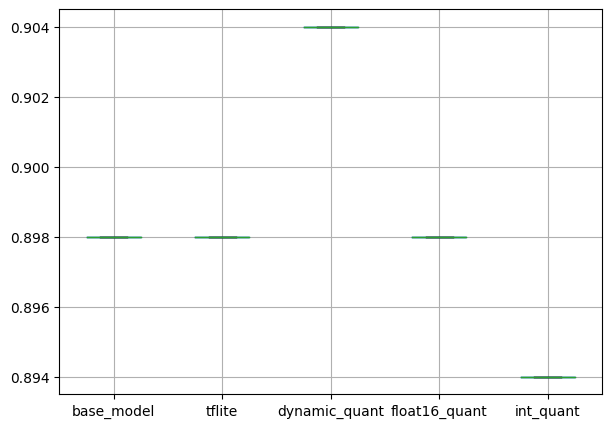

In [ ]:
pd.DataFrame(Acc_results).boxplot(figsize=(7, 5))
plt.show()

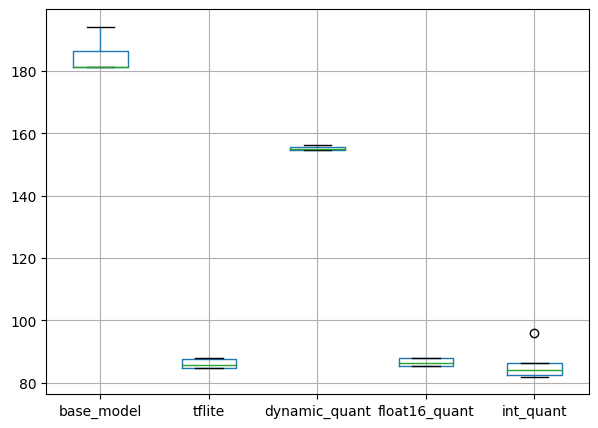

In [ ]:
pd.DataFrame(Time_results).boxplot(figsize=(7, 5))
plt.show()

In [ ]:
import math
import os

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

In [ ]:
base_model_size = get_dir_size('/content/drive/MyDrive/Base_Model')
tflite_size = os.path.getsize('/content/tflite_models/base_model.tflite')
dynamic_quant_size = os.path.getsize('/content/tflite_models/dynamic_quant_model.tflite')
float16_quant_size = os.path.getsize('/content/tflite_models/float16_quant_model.tflite')
int_quant_size = os.path.getsize('/content/tflite_models/int_quant_model.tflite')

print('Base Model Size:', convert_size(base_model_size), 'bytes')
print('TFLite Size:', convert_size(tflite_size), 'bytes')
print('Dynamic Quant Size:', convert_size(dynamic_quant_size), 'bytes')
print('Float16 Quant Size:', convert_size(float16_quant_size), 'bytes')
print('Int Quant Size:', convert_size(int_quant_size), 'bytes')

Base Model Size: 93.43 MB bytes
TFLite Size: 89.69 MB bytes
Dynamic Quant Size: 22.83 MB bytes
Float16 Quant Size: 44.88 MB bytes
Int Quant Size: 23.14 MB bytes
